In [5]:
library(ggplot2)

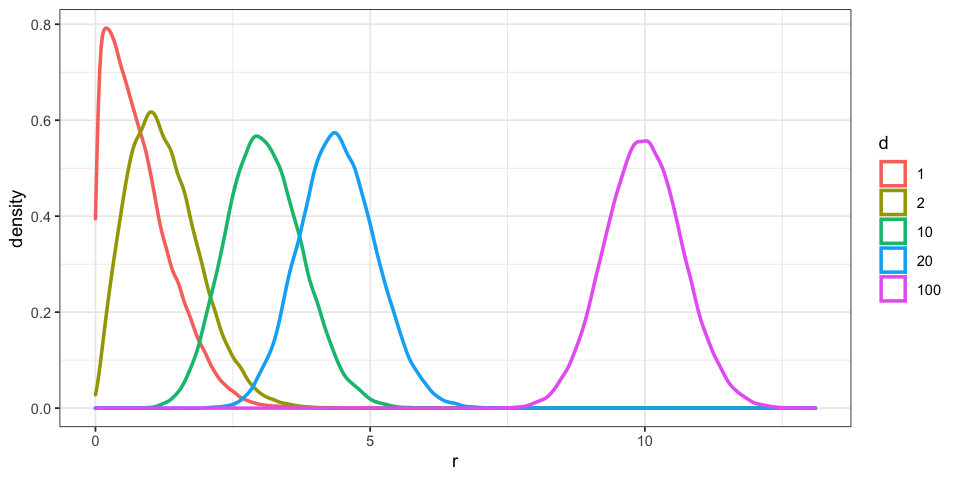

In [6]:
sample_distance_from_origin <- function(d, n=50000) {
    x <- matrix(rnorm(n*d), nrow=n)
    r <- sqrt(rowSums(x^2))
    r
}

x <- NULL
for (d in c(1,2,10,20,100)) {
    r <- sample_distance_from_origin(d)
    tmp <- data.frame(d=d, r=r)
    x <- rbind(x, tmp)
}
x$d <- factor(x$d)

options(repr.plot.width=8, repr.plot.height=4)
ggplot(x, aes(r, color=d)) + geom_density(size=1) + theme_bw()

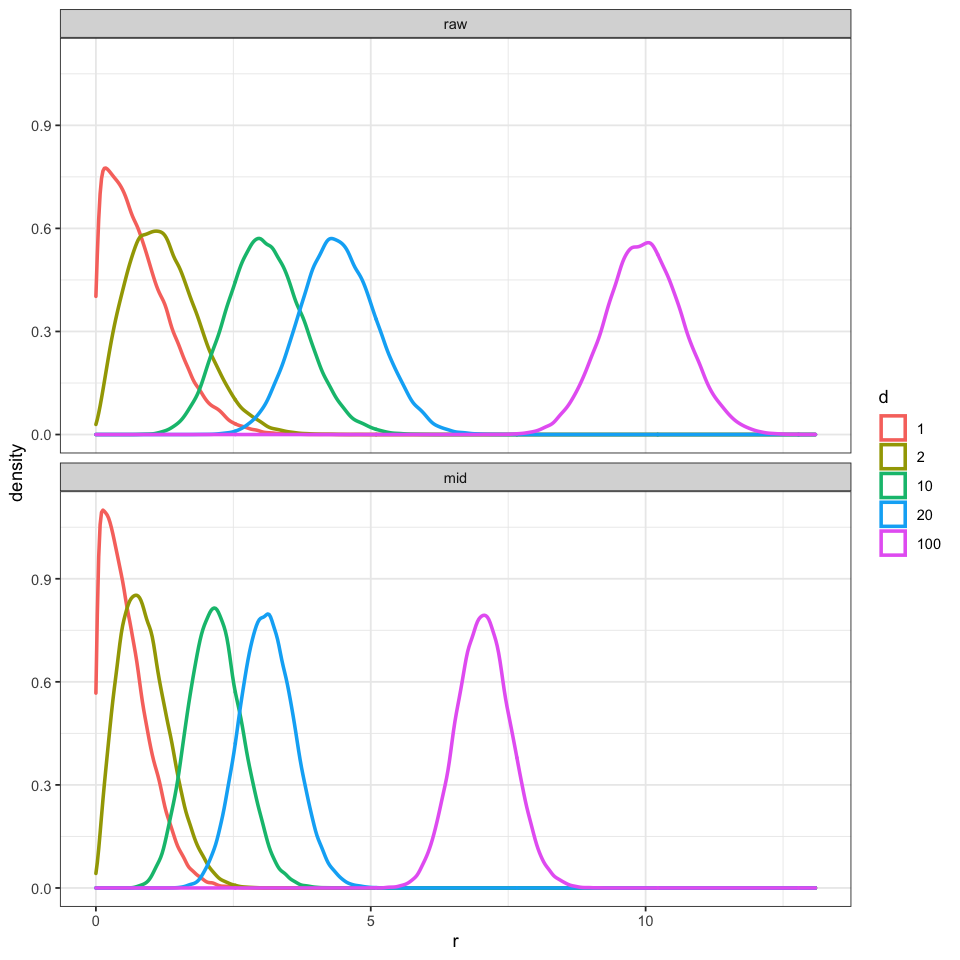

In [7]:
sample_distance_from_origin_midpoint <- function(d, n=50000) {
    x1 <- matrix(rnorm(n*d), nrow=n)
    x2 <- matrix(rnorm(n*d), nrow=n)
    x <- (x1 + x2) / 2
    r <- sqrt(rowSums(x^2))
    r
}

x <- NULL
for (d in c(1,2,10,20,100)) {
    r <- sample_distance_from_origin(d)
    tmp <- data.frame(d=d, type="raw", r=r)
    x <- rbind(x, tmp)
    
    r <- sample_distance_from_origin_midpoint(d)
    tmp <- data.frame(d=d, type="mid", r=r)
    x <- rbind(x, tmp)    
}
x$d <- factor(x$d)
x$type <- factor(x$type, levels=c("raw", "mid"))

options(repr.plot.width=8, repr.plot.height=8)
ggplot(x, aes(r, color=d)) + geom_density(size=1) + facet_wrap(vars(type), ncol=1) + theme_bw()

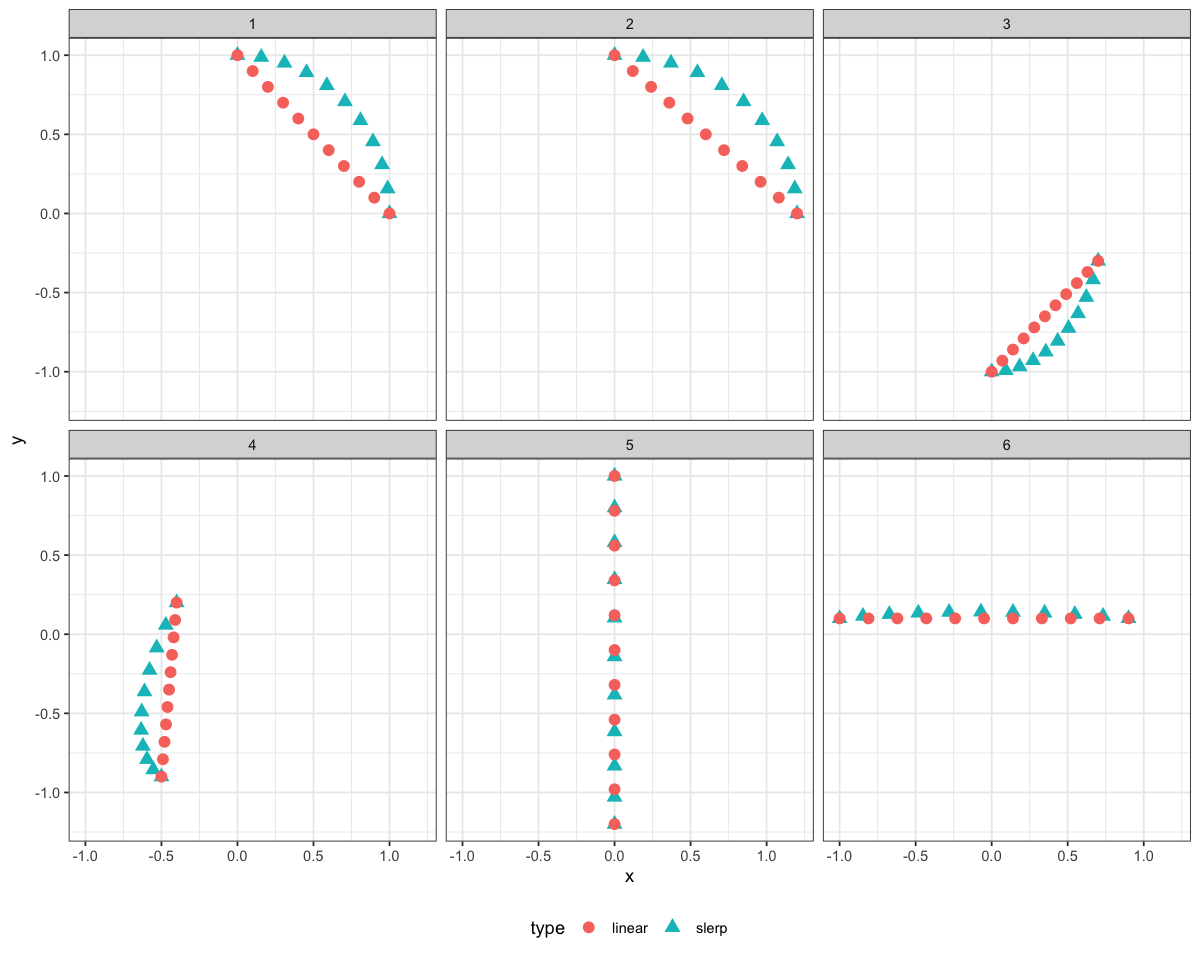

In [65]:
slerp <- function(p0, p1, t) {
    # returns interpolated position between p0 and p1
    # t is the closeness to p1
    # t=0 -> p0, t=1 -> p1
    # t in (0,1) -> somewhere between them
    # cf: https://en.wikipedia.org/wiki/Slerp
    prod <- max(0, min(1, sum(p0*p1)))
    omega <- acos(prod)
    if (omega == 0) {
        (1-t)*p0 + t*p1
    } else {
        sin((1-t)*omega) / sin(omega) * p0 + sin(t*omega) / sin(omega) * p1
    }
}

interpolations <- function(p0, p1, by=0.1) {
    x <- NULL
    for (t in seq(0, 1, by=by)) {
        a <- slerp(p0, p1, t)
        tmp <- data.frame(x=a[1], y=a[2], type="slerp", stringsAsFactors=FALSE)
        x <- rbind(x, tmp)
        a <- (1-t)*p0 + t*p1
        tmp <- data.frame(x=a[1], y=a[2], type="linear", stringsAsFactors=FALSE)
        x <- rbind(x, tmp)
    }  
    x
}

points <- list(
    list(c(0, 1), c(1, 0)),
    list(c(0, 1), c(1.2, 0)),
    list(c(0, -1), c(0.7, -0.3)),
    list(c(-0.4, 0.2), c(-0.5, -0.9)),
    list(c(0, 1), c(0, -1.2)),
    list(c(-1, 0.1), c(0.9, 0.1))
)
x <- NULL
for (i in seq_along(points)) {
    p <- points[[i]]
    tmp <- interpolations(p[[1]], p[[2]])
    tmp$example <- i
    x <- rbind(x, tmp)
}

options(repr.plot.width=10, repr.plot.height=8)
ggplot(x, aes(x, y, color=type, shape=type)) + 
    geom_point(size=3) + facet_wrap(vars(example)) +
    theme_bw() + theme(legend.position="bottom")